In [ ]:
!rm -r dataset_aumentado/
!wget --output-document dataset.zip https:/examplew/dataset_aumentado_todas.zip?dl=0
!unzip -o -q dataset.zip
!pip install lime

rm: cannot remove 'dataset_aumentado/': No such file or directory
--2021-01-16 18:56:19--  https://www.dropbox.com/s/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip [following]
--2021-01-16 18:56:19--  https://www.dropbox.com/s/raw/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4ddde444522ae86d4691eaf457.dl.dropboxusercontent.com/cd/0/inline/BHLEJzEiNMXWQjPZIzvwBwfYikSJ04810_naucPhoDANkIN997UxtFI8mEOI0eRkWIn6wSslgI1yHD-ixPwdzimBxF8fvu7CGZCmQRtQHGu2rw64DIljsTnAHi9QIVI0E4Q/file# [following]
--2021-01-16 18:56:20--  https://uc4ddde444522ae86d4691eaf457.dl.dropboxusercontent.com/cd/0/in

Imports:

In [ ]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras import backend as K
from sklearn import metrics
import itertools
print('Notebook run using keras:', keras.__version__)


Notebook run using keras: 2.4.3


Define diretórios

In [ ]:
diretorio = 'dataset_aumentado'
train_directory = os.path.join(diretorio, 'train')
val_directory = os.path.join(diretorio, 'validation')
test_directory = os.path.join(diretorio, 'test')

Monta google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Define modelo:

In [ ]:
#definicao do modelo
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam,RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.applications.xception import preprocess_input
target_size_dimension = 300
diretorio_pesos = '/content/gdrive/MyDrive/weight_exp_decay_20210114-1249.h5'
model = keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(target_size_dimension, target_size_dimension, 3)
)
x = Dense(40, activation='relu')(model.output)
x = Dropout(0.25)(x)
output = Dense(12, activation='softmax')(x)
nmodel = keras.models.Model(model.input, output)

nmodel.load_weights(diretorio_pesos)

Matriz de confusão:

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_matrix(test_data_generator, model):
  test_data_generator.reset()
  predictions = model.predict(test_data_generator, steps=test_set.samples)
  # Get most likely class
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = test_data_generator.classes
  class_labels = list(test_data_generator.class_indices.keys())
  print(class_labels)  

  report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
  cm = metrics.confusion_matrix(true_classes, predicted_classes)
  print(report)
  plot_confusion_matrix(cm, class_labels)

Transforma lista de imagens de teste:

In [ ]:
import pandas as pd
import glob
#metodo que itera pelos arquivos do diretorio salvando a path da imagem e sua respectiva classe
def directory_from_df_with_class(df, directory):
  for r, d, f in os.walk(directory):
    for file in f:
      row = {}
      row['path'] = os.path.join(r, file)
      
      row['class'] = row['path'].split('/')[-2]
      #print(row['class'])
      df= df.append(row, ignore_index=True)
  return df

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(target_size_dimension, target_size_dimension))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

columns_df = ['path', 'class']
df = pd.DataFrame(columns=columns_df)

df = directory_from_df_with_class(df, test_directory)

test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)
test_set = test_datagen.flow_from_directory(test_directory, 
                                            target_size=(target_size_dimension, target_size_dimension),
                                            class_mode='categorical',
                                            batch_size=1,
                                            shuffle=False)

test_set.reset()
predictions = nmodel.predict(test_set, steps=test_set.samples)


Found 72 images belonging to 12 classes.


Plotagem da matriz:

['Codega', 'Malvasia Fina', 'Malvasia Preta', 'Malvasia Rei', 'Moscatel Galego', 'Mourisco Tinto', 'Rabigato', 'Tinta Amarela', 'Tinta Barroca', 'Tinta Roriz', 'Tinto Cao', 'Touriga Nacional']
                  precision    recall  f1-score   support

          Codega       1.00      0.33      0.50         6
   Malvasia Fina       0.83      0.83      0.83         6
  Malvasia Preta       0.86      1.00      0.92         6
    Malvasia Rei       0.60      1.00      0.75         6
 Moscatel Galego       1.00      1.00      1.00         6
  Mourisco Tinto       1.00      0.83      0.91         6
        Rabigato       1.00      1.00      1.00         6
   Tinta Amarela       1.00      1.00      1.00         6
   Tinta Barroca       0.86      1.00      0.92         6
     Tinta Roriz       1.00      1.00      1.00         6
       Tinto Cao       1.00      1.00      1.00         6
Touriga Nacional       1.00      0.83      0.91         6

        accuracy                           0.90    

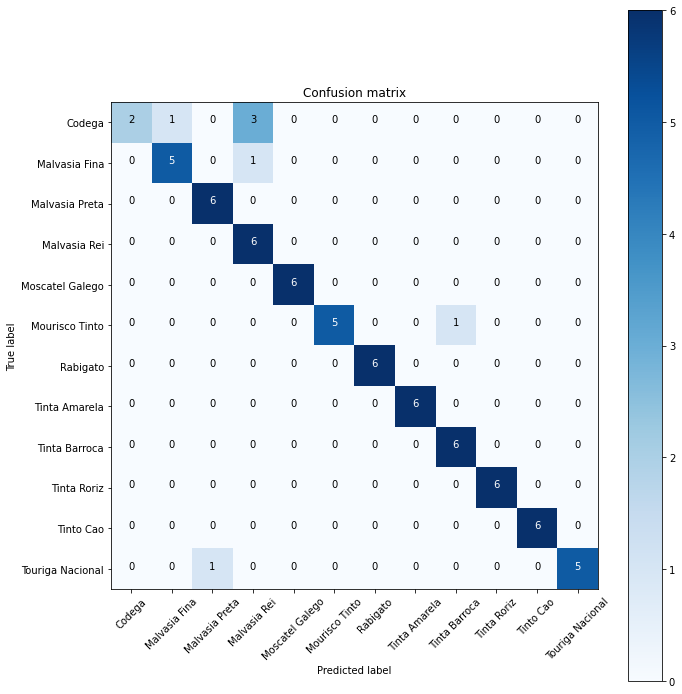

In [ ]:
confusion_matrix(test_set, nmodel)

Verifica imagens que foram previstas errôneamente:

dataset_aumentado/test/Codega/IMG_0320.JPG :


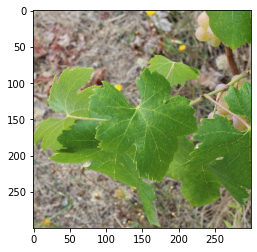

('Malvasia Rei', 0.9994675517082214)
('Malvasia Preta', 0.0002583235327620059)
('Codega', 0.00014487183943856508)
('Malvasia Fina', 6.6292384872213e-05)
('Moscatel Galego', 1.4311051018012222e-05)
indice uitlizado pelo explicador:  2
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs



para a classe que deveria ter sido prevista: 


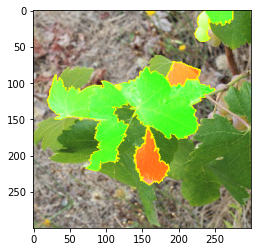

para a classe que foi prevista: 


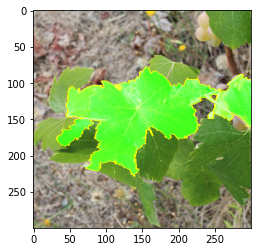

dataset_aumentado/test/Codega/IMG_0327.JPG :


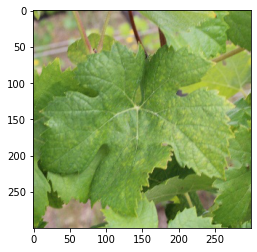

('Malvasia Fina', 0.5496772527694702)
('Codega', 0.4072939455509186)
('Malvasia Rei', 0.02504066564142704)
('Rabigato', 0.011810097843408585)
('Touriga Nacional', 0.003036819165572524)
indice uitlizado pelo explicador:  1
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs



para a classe que deveria ter sido prevista: 


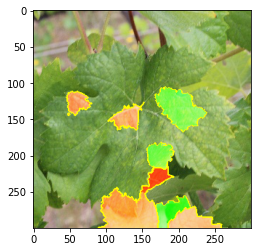

para a classe que foi prevista: 


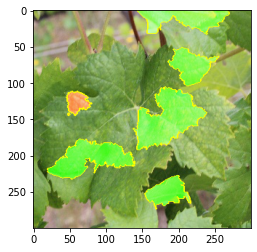

dataset_aumentado/test/Codega/IMG_0350.JPG :


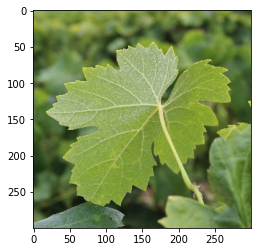

('Malvasia Rei', 0.9389413595199585)
('Codega', 0.0461038202047348)
('Malvasia Fina', 0.005436863284558058)
('Moscatel Galego', 0.005375892389565706)
('Malvasia Preta', 0.0012670884607359767)
indice uitlizado pelo explicador:  1
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs



para a classe que deveria ter sido prevista: 


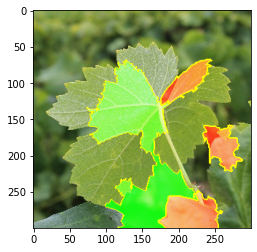

para a classe que foi prevista: 


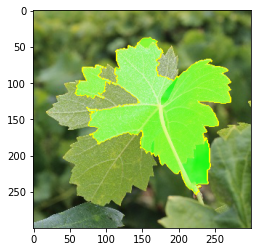

dataset_aumentado/test/Codega/IMG_0357.JPG :


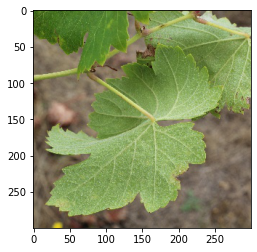

('Malvasia Rei', 0.98121577501297)
('Codega', 0.005014241673052311)
('Moscatel Galego', 0.00435900641605258)
('Tinta Roriz', 0.003254363778978586)
('Malvasia Preta', 0.002132620895281434)
indice uitlizado pelo explicador:  1
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs



para a classe que deveria ter sido prevista: 


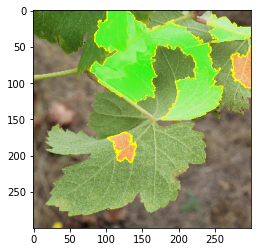

para a classe que foi prevista: 


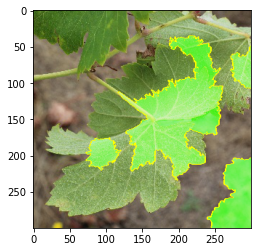

dataset_aumentado/test/Malvasia Fina/IMG_9891.JPG :


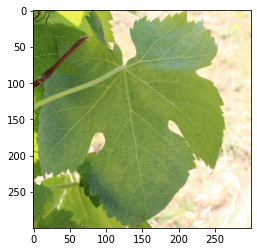

('Malvasia Rei', 0.8283730745315552)
('Malvasia Fina', 0.08611493557691574)
('Mourisco Tinto', 0.03644685074687004)
('Moscatel Galego', 0.02219696156680584)
('Tinto Cao', 0.012514503672719002)
indice uitlizado pelo explicador:  1
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs



para a classe que deveria ter sido prevista: 


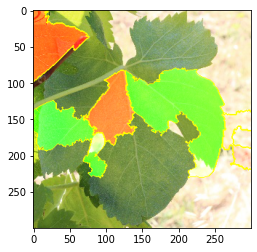

para a classe que foi prevista: 


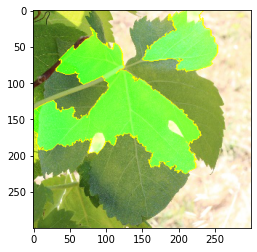

dataset_aumentado/test/Mourisco Tinto/IMG_0146.JPG :


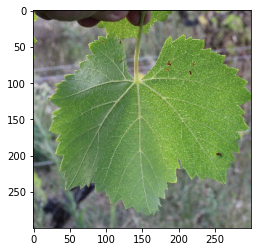

('Tinta Barroca', 0.5590984225273132)
('Mourisco Tinto', 0.23473294079303741)
('Moscatel Galego', 0.09993404150009155)
('Malvasia Preta', 0.03278276324272156)
('Malvasia Rei', 0.028277117758989334)
indice uitlizado pelo explicador:  1
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs



para a classe que deveria ter sido prevista: 


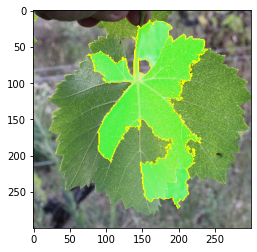

para a classe que foi prevista: 


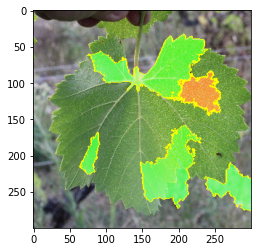

dataset_aumentado/test/Touriga Nacional/IMG_0637.JPG :


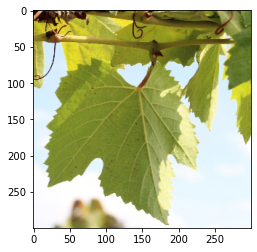

('Malvasia Preta', 0.6435747742652893)
('Tinto Cao', 0.07818912714719772)
('Moscatel Galego', 0.07048586755990982)
('Tinta Roriz', 0.05575280264019966)
('Rabigato', 0.04222292825579643)
indice uitlizado pelo explicador:  0
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs



para a classe que deveria ter sido prevista: 


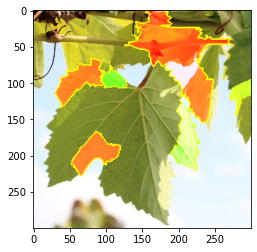

para a classe que foi prevista: 


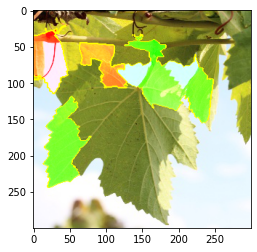

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_set.classes

erros = np.where(predicted_classes != true_classes)[0]

paths=[]
for i in erros:
  paths.append(test_set.filepaths[i])

#importa lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

def decode_preds(preds, top=5):
  labels=(test_set.class_indices)
  labels2=dict((v,k) for k,v in labels.items())

  preds_return = []
  for pred in preds:
    sorted = -np.sort(-pred)[:top]
    pred = pred.tolist()
    greaters = [pred.index(x) for x in sorted]
    list2 = []
    for g in greaters:
      list2.append((labels2[g], pred[g]))
    
    preds_return.append(list2)
  
  return preds_return 

for i, img_path in enumerate(paths):
  print(img_path, ':')
  img = transform_img_fn([img_path])
  plt.figure()
  plt.imshow(img[0]/2+0.5)
  plt.show()
  preds = nmodel.predict(img)
  #print(preds)
  
  class_img = img_path.split(os.path.sep)[-2]
  index = 0
  for i, x in enumerate(decode_preds(preds)[0]):
    print(x)
    if x[0] == class_img:
      index = i
  print('indice uitlizado pelo explicador: ', index)
  plt.figure()
  explainer = lime_image.LimeImageExplainer()
  %%time
  # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
  explanation = explainer.explain_instance(img[0].astype('double'), nmodel.predict, top_labels=5, hide_color=0, num_samples=1000)

  print('para a classe que deveria ter sido prevista: ')
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=10, hide_rest=False)
  plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
  plt.show()

  print('para a classe que foi prevista: ')
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
  plt.show()

  print('===============================')
  print('===============================')




  


In [ ]:
labels=(test_set.class_indices)
labels2=dict((v,k) for k,v in labels.items())

print(labels)
print(labels2)

{'Codega': 0, 'Malvasia Fina': 1, 'Malvasia Preta': 2, 'Malvasia Rei': 3, 'Moscatel Galego': 4, 'Mourisco Tinto': 5, 'Rabigato': 6, 'Tinta Amarela': 7, 'Tinta Barroca': 8, 'Tinta Roriz': 9, 'Tinto Cao': 10, 'Touriga Nacional': 11}
{0: 'Codega', 1: 'Malvasia Fina', 2: 'Malvasia Preta', 3: 'Malvasia Rei', 4: 'Moscatel Galego', 5: 'Mourisco Tinto', 6: 'Rabigato', 7: 'Tinta Amarela', 8: 'Tinta Barroca', 9: 'Tinta Roriz', 10: 'Tinto Cao', 11: 'Touriga Nacional'}
